Классы: ['Входящий', 'Выходящий'], всего классов: 2


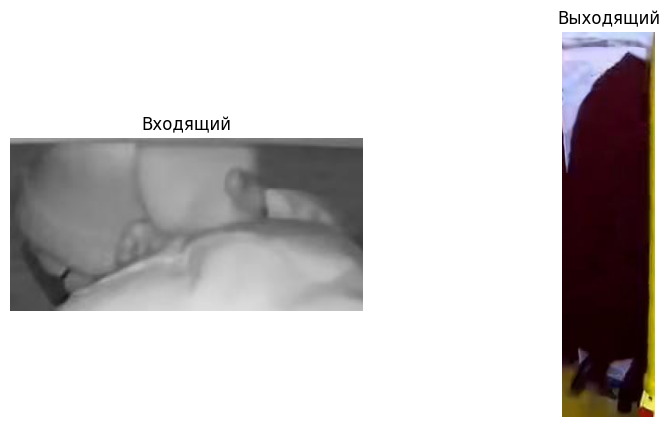

🔄 Класс "Входящий" нуждается в 0 дополнительных изображениях.
🔄 Класс "Выходящий" нуждается в 3889 дополнительных изображениях.
✅ Аугментация завершена.



In [1]:
import gdown
import os
import matplotlib.pyplot as plt
from PIL import Image
import random

# Скачивание и распаковка архива
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)
!unzip -q "bus.zip" -d /content/bus
IMAGE_PATH = '/content/bus/'

# Информация о классах
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))
CLASS_COUNT = len(CLASS_LIST)
print(f'Классы: {CLASS_LIST}, всего классов: {CLASS_COUNT}')

# Отображение по одному случайному изображению из каждого класса
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))
for i, class_name in enumerate(CLASS_LIST):
    class_path = os.path.join(IMAGE_PATH, class_name)
    img_path = os.path.join(class_path, random.choice(os.listdir(class_path)))
    axs[i].imshow(Image.open(img_path))
    axs[i].set_title(class_name)
    axs[i].axis('off')
plt.show()


from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

IMG_SIZE = (224, 224)

augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Подсчёт и аугментация
class_counts = {}
for cls in CLASS_LIST:
    class_path = os.path.join(IMAGE_PATH, cls)
    count = len(os.listdir(class_path))
    class_counts[cls] = count

max_count = max(class_counts.values())

augmented_images = []  # Список для хранения путей и меток аугментированных изображений

for cls in CLASS_LIST:
    class_path = os.path.join(IMAGE_PATH, cls)
    images = os.listdir(class_path)
    deficit = max_count - len(images)
    print(f'🔄 Класс "{cls}" нуждается в {deficit} дополнительных изображениях.')

    if deficit > 0:
        i = 0
        while deficit > 0:
            img_name = images[i % len(images)]
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=IMG_SIZE)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            aug_iter = augmentor.flow(x, batch_size=1)
            aug_img = next(aug_iter)[0]
            aug_img_pil = array_to_img(aug_img)

            aug_img_name = f'aug_{i}.jpg'
            aug_img_pil.save(os.path.join(class_path, aug_img_name))

            # Добавление пути и метки в список для аугментированных изображений
            augmented_images.append((os.path.join(class_path, aug_img_name), cls))

            i += 1
            deficit -= 1

print("✅ Аугментация завершена.\n")

# Теперь список `augmented_images` содержит пути и метки для аугментированных изображений.


In [2]:
import os
import cv2
import numpy as np
from PIL import Image

# Размер изображений
IMG_SIZE = (128, 128)

# Функция для преобразования в черно-белое изображение и удаления шума
def preprocess_image(img_path):
    # Открываем изображение
    img = Image.open(img_path)

    # Преобразуем изображение в черно-белое
    img_gray = img.convert('L')  # 'L' - это режим для черно-белого изображения

    # Преобразуем изображение в массив numpy
    img_array = np.array(img_gray)

    # Применяем фильтр для удаления шума (медианный фильтр)
    img_array = cv2.medianBlur(img_array, 3)  # 3 — размер ядра для медианного фильтра

    # Преобразуем обратно в изображение
    img_clean = Image.fromarray(img_array)

    # Преобразуем изображение в нужный размер
    img_clean = img_clean.resize(IMG_SIZE)

    return img_clean

# Путь к изображениям
IMAGE_PATH = '/content/bus/'

# Проходим по всем классам
for cls in os.listdir(IMAGE_PATH):
    class_path = os.path.join(IMAGE_PATH, cls)

    if os.path.isdir(class_path):
        # Проходим по всем изображениям в классе
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # Применяем преобразование к изображению
            img_clean = preprocess_image(img_path)

            # Сохраняем очищенное изображение обратно в класс
            img_clean_path = os.path.join(class_path, f'clean_{img_name}')
            img_clean.save(img_clean_path)

print("✅ Преобразование и очистка изображений завершены.")


✅ Преобразование и очистка изображений завершены.


In [3]:
from PIL import Image

fixed_count = 0

for cls in CLASS_LIST:
    class_path = os.path.join(IMAGE_PATH, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                if img.size != IMG_SIZE:
                    img = img.resize(IMG_SIZE)
                    img.save(img_path)
                    fixed_count += 1
        except Exception as e:
            print(f"⚠️ Проблема с файлом {img_path}: {e}")

print(f"✅ Изменено изображений: {fixed_count}. Все изображения теперь имеют размер {IMG_SIZE}")


✅ Изменено изображений: 12970. Все изображения теперь имеют размер (128, 128)


In [4]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image

X = []
y = []

for cls in CLASS_LIST:
    class_path = os.path.join(IMAGE_PATH, cls)
    for img_name in os.listdir(class_path):
        if img_name.endswith(".jpg") or img_name.endswith(".png"):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path).convert('L')  # черно-белое
                img = img.resize(IMG_SIZE)
                img_array = np.array(img)
                img_array = np.expand_dims(img_array, axis=-1)  # (H, W, 1)
                X.append(img_array)
                y.append(cls)
            except Exception as e:
                print(f"⚠️ Пропущено {img_path}: {e}")

# Преобразуем в numpy и нормализуем
X = np.array(X, dtype='float32') / 255.0
y = np.array(y)

# Преобразуем метки в one-hot
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

# Разделим на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded)

print(f'✅ Данные готовы!\nX_train: {X_train.shape}, y_train: {y_train.shape}\nX_val: {X_val.shape}, y_val: {y_val.shape}')


✅ Данные готовы!
X_train: (20752, 128, 128, 1), y_train: (20752, 2)
X_val: (5188, 128, 128, 1), y_val: (5188, 2)


In [5]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Input(shape=(128, 128, 1)),  # <-- теперь через Input
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])


In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.6911 - loss: 0.5558 - val_accuracy: 0.9108 - val_loss: 0.2256
Epoch 2/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9123 - loss: 0.2135 - val_accuracy: 0.9362 - val_loss: 0.1427
Epoch 3/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9587 - loss: 0.1078 - val_accuracy: 0.9738 - val_loss: 0.0701
Epoch 4/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9756 - loss: 0.0669 - val_accuracy: 0.9830 - val_loss: 0.0514
Epoch 5/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9805 - loss: 0.0524 - val_accuracy: 0.9880 - val_loss: 0.0347
Epoch 6/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9852 - loss: 0.0467 - val_accuracy: 0.9892 - val_loss: 0.0331
Epoch 7/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9870 - loss: 0.0346 - val_accuracy: 0.9925 - val_loss: 0.0219
Epoch 8/20
649/649 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9879 - loss: 0.0336 - 

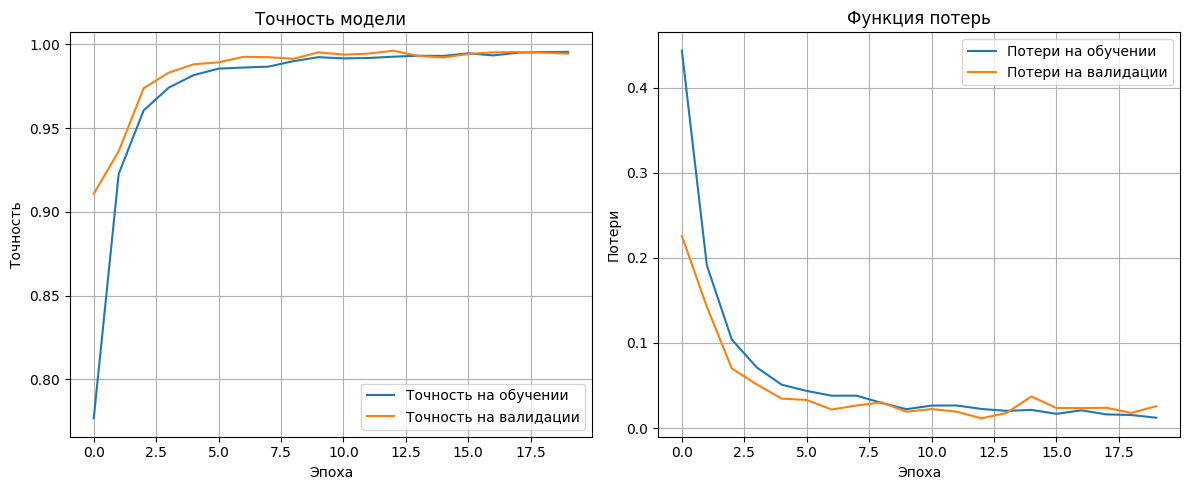

In [9]:
import matplotlib.pyplot as plt

# Точность (accuracy)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.title('Точность модели')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

# Потери (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
